# SECTION 1: DECLARE THE MODULES

In [1]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve

#import warnings
#warnings.filterwarnings('ignore')

from sklearn.metrics import ConfusionMatrixDisplay
import wget

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss
from sklearn.model_selection import GridSearchCV

data2_path = "C:/Users/singh/Documents/MastersAppliedAIDeakin/SIT719_Analytics_Security_Privacy/2020-S2-master/data/Processed_Combined_IoT_dataset.csv"
data2 = pd.read_csv(data2_path)
D1 = {} #Dict to store accuracy values from dataset 1
D2 = {} #Dict to store accuracy values from dataset 2

# SECTION 2: Data import and preprocess
#Run this but dont worry if it does not make any sense Jump to SECTION 3 that is related to your HD task.

In [2]:
!pip install wget
link_to_data = 'https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/training_attack_types.txt?raw=true'
DataSet = wget.download(link_to_data) 

100% [..................................................................................] 500 / 500

In [3]:
DataSet

'training_attack_types (5).txt'

In [4]:
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']


# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names 
# file, but it is supposed to be a binary feature according to the 
# dataset documentation

# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [5]:
# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

category = defaultdict(list)
category['benign'].append('normal')

with open(DataSet, 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

In [6]:
attack_mapping

{'normal': 'benign',
 'apache2': 'dos',
 'back': 'dos',
 'mailbomb': 'dos',
 'processtable': 'dos',
 'snmpgetattack': 'dos',
 'teardrop': 'dos',
 'smurf': 'dos',
 'land': 'dos',
 'neptune': 'dos',
 'pod': 'dos',
 'udpstorm': 'dos',
 'ps': 'u2r',
 'buffer_overflow': 'u2r',
 'perl': 'u2r',
 'rootkit': 'u2r',
 'loadmodule': 'u2r',
 'xterm': 'u2r',
 'sqlattack': 'u2r',
 'httptunnel': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'snmpguess': 'r2l',
 'imap': 'r2l',
 'spy': 'r2l',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'multihop': 'r2l',
 'phf': 'r2l',
 'named': 'r2l',
 'sendmail': 'r2l',
 'xlock': 'r2l',
 'xsnoop': 'r2l',
 'worm': 'probe',
 'nmap': 'probe',
 'ipsweep': 'probe',
 'portsweep': 'probe',
 'satan': 'probe',
 'mscan': 'probe',
 'saint': 'probe'}

In [7]:
#Processing Training Data

train_file='https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/KDDTrain%2B.txt'



train_df = pd.read_csv(train_file, names=header_names)

train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])

train_df.drop(['success_pred'], axis=1, inplace=True)






In [8]:
#Processing test Data
test_file='https://raw.githubusercontent.com/SIT719/2020-S2/master/data/Week_5_NSL-KDD-Dataset/KDDTest%2B.txt'

test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

<>:89: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:90: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:89: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:90: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-9-432fdc8d5f2a>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_x[numeric_cols] = \
C:\Users\singh\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value

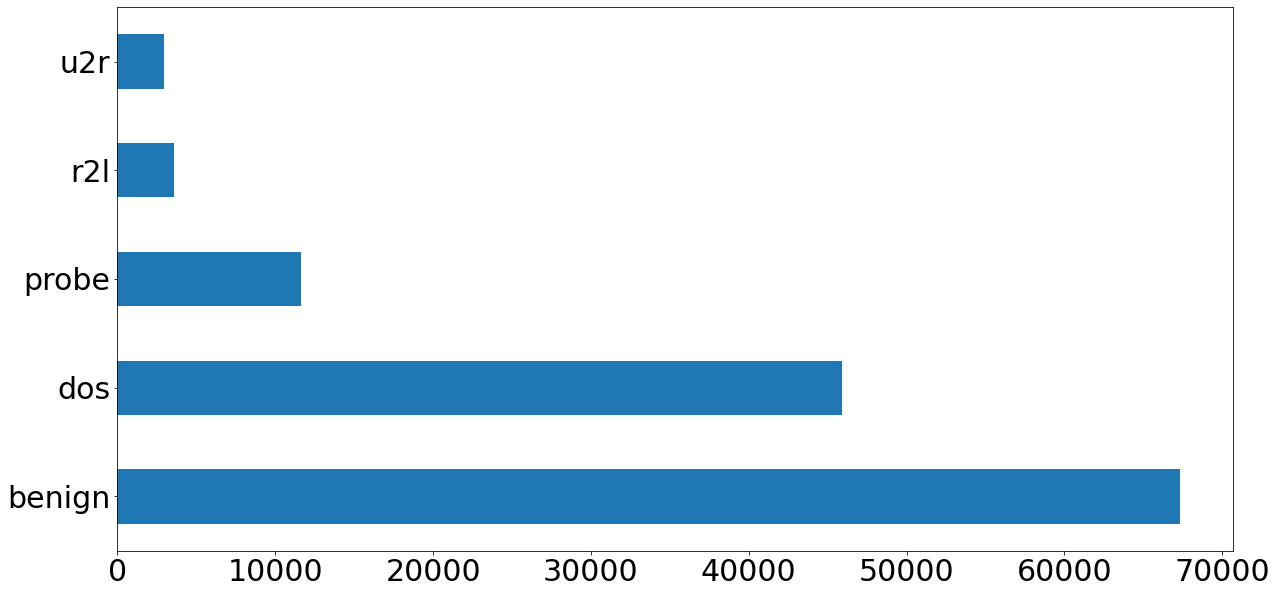

In [9]:
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

train_attack_types.plot(kind='barh', figsize=(20,10), fontsize=20)

train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

train_df[binary_cols].describe().transpose()
train_df.groupby(['su_attempted']).size()
train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()
train_df.groupby(['num_outbound_cmds']).size()

#Now, that's not a very useful feature - let's drop it from the dataset

train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
test_df.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')



#Data Preparation

train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category','attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category','attack_type'], axis=1)


combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

#execute the commands in console
train_x.describe()
train_x['duration'].describe()
# Experimenting with StandardScaler on the single 'duration' feature
from sklearn.preprocessing import StandardScaler

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()

# Experimenting with MinMaxScaler on the single 'duration' feature
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()

# Experimenting with RobustScaler on the single 'duration' feature
from sklearn.preprocessing import RobustScaler

min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Experimenting with MaxAbsScaler on the single 'duration' feature
from sklearn.preprocessing import MaxAbsScaler

max_Abs_scaler = MaxAbsScaler().fit(durations)
robust_scaled_durations = max_Abs_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()

# Let's proceed with StandardScaler- Apply to all the numeric columns

standard_scaler = StandardScaler().fit(train_x[numeric_cols])

train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])

test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])
    
train_x.describe()



train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)


# SECTION 3: Multi class classification
#This is the section where you have to add other algorithms, tune algorithms and visualize to compare and analyze algorithms
### Decision Tree

In [10]:
hyperparamsList = {'max_depth': np.arange(10, 50, 10).tolist(), 
                  }

clf = DecisionTreeClassifier()

grid = GridSearchCV(estimator=clf, param_grid=hyperparamsList, cv=2,
                    scoring='accuracy', n_jobs = 4)

grid.fit(train_x, train_Y)
print (grid.best_params_)

{'max_depth': 20}


[KDD-Dataset] Model Training Time for Decision Tree:  2.4197240999999963
[KDD-Dataset] Prediction Time for Decision Tree:  0.033972300000002065
[KDD-Dataset] Confusion Matrix for Decision Tree:
 [[9377   59  272    3    0]
 [1541 5998   97    0    0]
 [ 679  220 1524    0    0]
 [2316    0    8  247    3]
 [ 173    0    2    5   20]]
[KDD-Dataset] Classification Report for Decision Tree:
               precision    recall  f1-score   support

      benign       0.67      0.97      0.79      9711
         dos       0.96      0.79      0.86      7636
       probe       0.80      0.63      0.70      2423
         r2l       0.97      0.10      0.17      2574
         u2r       0.87      0.10      0.18       200

    accuracy                           0.76     22544
   macro avg       0.85      0.52      0.54     22544
weighted avg       0.81      0.76      0.73     22544

[KDD-Dataset] Precision Decision Tree:  0.814796424202564
[KDD-Dataset] Recall Decision Tree:  0.761444286728176
[KDD-D

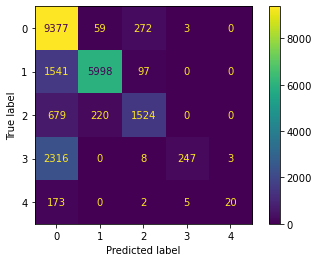

In [11]:
# 5-class classification version

start = timeit.default_timer()
clf = DecisionTreeClassifier(max_depth = grid.best_params_['max_depth'], random_state=17)

clf.fit(train_x, train_Y)

#Calculate Stop time
stop = timeit.default_timer()
train_time = stop - start

#Calculate start time
start = timeit.default_timer()

# Predict the model
y_pred=clf.predict(test_x)

#Calculate Stop time
stop = timeit.default_timer()
test_time= stop - start
results = confusion_matrix(test_Y, y_pred)


precision = metrics.precision_score(test_Y, y_pred, average="weighted")
recall = metrics.recall_score(test_Y, y_pred, average="weighted")
f1Score = metrics.f1_score(test_Y, y_pred, average="weighted")

cm_display = ConfusionMatrixDisplay(results).plot()

print ("[KDD-Dataset] Model Training Time for Decision Tree: ", train_time)
print ("[KDD-Dataset] Prediction Time for Decision Tree: ", test_time)
print("[KDD-Dataset] Confusion Matrix for Decision Tree:\n", results)
print("[KDD-Dataset] Classification Report for Decision Tree:\n", classification_report(test_Y,y_pred))
print("[KDD-Dataset] Precision Decision Tree: ", precision)
print("[KDD-Dataset] Recall Decision Tree: ", recall)
print("[KDD-Dataset] F1 score Decision Tree: ", f1Score)

#Taken from: 
#https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py
FP = results.sum(axis=0) - np.diag(results)  
FN = results.sum(axis=1) - np.diag(results)
TP = np.diag(results)
TN = results.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
FPR = FP.sum()/(FP.sum()+TN.sum())

print("FPR: ", FPR)
D1['DT'] = metrics.accuracy_score(test_Y, y_pred)

#### KNN

[KDD-Dataset] Model Training Time for KNN:  0.14264639999964857
[KDD-Dataset] Prediction Time for KNN:  52.846228399999745
[KDD-Dataset] Confusion Matrix for KNN:
 [[9444   54  207    5    1]
 [1630 5925   81    0    0]
 [ 614  180 1629    0    0]
 [2362    2   40  170    0]
 [ 170    0   17    4    9]]
[KDD-Dataset] Classification Report for KNN:
               precision    recall  f1-score   support

      benign       0.66      0.97      0.79      9711
         dos       0.96      0.78      0.86      7636
       probe       0.83      0.67      0.74      2423
         r2l       0.95      0.07      0.12      2574
         u2r       0.90      0.04      0.09       200

    accuracy                           0.76     22544
   macro avg       0.86      0.51      0.52     22544
weighted avg       0.82      0.76      0.73     22544

[KDD-Dataset] Precision KNN:  0.8169367895224233
[KDD-Dataset] Recall KNN:  0.7619322214336409
[KDD-Dataset] F1 score KNN:  0.7253992182451958
FPR:  0.059516944

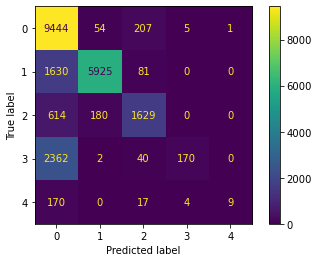

In [12]:
from sklearn.neighbors import KNeighborsClassifier

start = timeit.default_timer()
clf = KNeighborsClassifier()
clf.fit(train_x, train_Y)

#Calculate Stop time
stop = timeit.default_timer()
train_time = stop - start

#Calculate start time
start = timeit.default_timer()

# Predict the model 
y_pred=clf.predict(test_x)

#Calculate Stop time
stop = timeit.default_timer()
test_time= stop - start
results = confusion_matrix(test_Y,y_pred)


precision = metrics.precision_score(test_Y, y_pred, average="weighted")
recall = metrics.recall_score(test_Y, y_pred, average="weighted")
f1Score = metrics.f1_score(test_Y, y_pred, average="weighted")

cm_display = ConfusionMatrixDisplay(results).plot()

print ("[KDD-Dataset] Model Training Time for KNN: ", train_time)
print ("[KDD-Dataset] Prediction Time for KNN: ", test_time)
print("[KDD-Dataset] Confusion Matrix for KNN:\n", results)
print("[KDD-Dataset] Classification Report for KNN:\n", classification_report(test_Y,y_pred))
print("[KDD-Dataset] Precision KNN: ", precision)
print("[KDD-Dataset] Recall KNN: ", recall)
print("[KDD-Dataset] F1 score KNN: ", f1Score)
#Taken from: 
#https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py
FP = results.sum(axis=0) - np.diag(results)  
FN = results.sum(axis=1) - np.diag(results)
TP = np.diag(results)
TN = results.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
FPR = FP.sum()/(FP.sum()+TN.sum())

print("FPR: ", FPR)
D1['KNN'] = metrics.accuracy_score(test_Y, y_pred)

#### SVM

[KDD-Dataset] Model Training Time for SVM:  81.30716839999877
[KDD-Dataset] Prediction Time for SVM:  429.9792696000004
[KDD-Dataset] Confusion Matrix for SVM:
 [[9462   62  187    0    0]
 [1882 5693   61    0    0]
 [ 836  175 1412    0    0]
 [2318    0    4  252    0]
 [ 177    0   15    3    5]]
[KDD-Dataset] Classification Report for SVM:
               precision    recall  f1-score   support

      benign       0.64      0.97      0.78      9711
         dos       0.96      0.75      0.84      7636
       probe       0.84      0.58      0.69      2423
         r2l       0.99      0.10      0.18      2574
         u2r       1.00      0.03      0.05       200

    accuracy                           0.75     22544
   macro avg       0.89      0.49      0.51     22544
weighted avg       0.82      0.75      0.71     22544

[KDD-Dataset] Precision SVM:  0.8150099156636176
[KDD-Dataset] Recall SVM:  0.7462739531582683
[KDD-Dataset] F1 score SVM:  0.7133283906613614
FPR:  0.063431511710

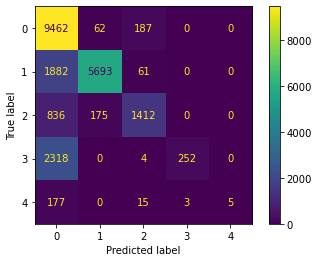

In [13]:
from sklearn.svm import SVC 

start = timeit.default_timer()
clf = SVC(kernel='rbf') 
clf.fit(train_x, train_Y)

#Calculate Stop time
stop = timeit.default_timer()
train_time = stop - start

#Calculate start time
start = timeit.default_timer()

# Predict the model
y_pred=clf.predict(test_x)

#Calculate Stop time
stop = timeit.default_timer()
test_time= stop - start
results = confusion_matrix(test_Y,y_pred)


precision = metrics.precision_score(test_Y, y_pred, average="weighted")
recall = metrics.recall_score(test_Y, y_pred, average="weighted")
f1Score = metrics.f1_score(test_Y, y_pred, average="weighted")

cm_display = ConfusionMatrixDisplay(results).plot()

print ("[KDD-Dataset] Model Training Time for SVM: ", train_time)
print ("[KDD-Dataset] Prediction Time for SVM: ", test_time)
print("[KDD-Dataset] Confusion Matrix for SVM:\n", results)
print("[KDD-Dataset] Classification Report for SVM:\n", classification_report(test_Y,y_pred))
print("[KDD-Dataset] Precision SVM: ", precision)
print("[KDD-Dataset] Recall SVM: ", recall)
print("[KDD-Dataset] F1 score SVM: ", f1Score)
#Taken from: 
#https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py
FP = results.sum(axis=0) - np.diag(results)  
FN = results.sum(axis=1) - np.diag(results)
TP = np.diag(results)
TN = results.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
FPR = FP.sum()/(FP.sum()+TN.sum())

print("FPR: ", FPR)
D1['SVM'] = metrics.accuracy_score(test_Y, y_pred)

#### MLP

C:\Users\singh\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[KDD-Dataset] Model Training Time for MLP:  27.760867300001337
[KDD-Dataset] Prediction Time for MLP:  0.03590330000042741
[KDD-Dataset] Confusion Matrix for MLP:
 [[9044  372  257   38    0]
 [1792 5677  166    1    0]
 [ 491  164 1768    0    0]
 [1955  259    3  357    0]
 [ 180    7    0   13    0]]


C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[KDD-Dataset] Classification Report for MLP:
               precision    recall  f1-score   support

      benign       0.67      0.93      0.78      9711
         dos       0.88      0.74      0.80      7636
       probe       0.81      0.73      0.77      2423
         r2l       0.87      0.14      0.24      2574
         u2r       0.00      0.00      0.00       200

    accuracy                           0.75     22544
   macro avg       0.65      0.51      0.52     22544
weighted avg       0.77      0.75      0.72     22544

[KDD-Dataset] Precision MLP:  0.7724483293331498
[KDD-Dataset] Recall MLP:  0.747249822569198
[KDD-Dataset] F1 score MLP:  0.7183369798925279
FPR:  0.06318754435770049


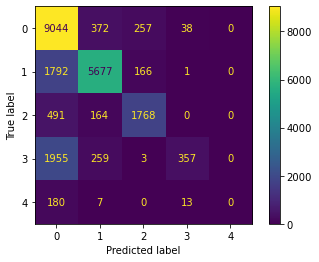

In [14]:
from sklearn.neural_network import MLPClassifier

start = timeit.default_timer()

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(train_x, train_Y)

#Calculate Stop time
stop = timeit.default_timer()
train_time = stop - start

#Calculate start time
start = timeit.default_timer()

# Predict the model
y_pred=clf.predict(test_x)

#Calculate Stop time
stop = timeit.default_timer()
test_time= stop - start
results = confusion_matrix(test_Y,y_pred)


precision = metrics.precision_score(test_Y, y_pred, average="weighted")
recall = metrics.recall_score(test_Y, y_pred, average="weighted")
f1Score = metrics.f1_score(test_Y, y_pred, average="weighted")

cm_display = ConfusionMatrixDisplay(results).plot()

print ("[KDD-Dataset] Model Training Time for MLP: ", train_time)
print ("[KDD-Dataset] Prediction Time for MLP: ", test_time)
print("[KDD-Dataset] Confusion Matrix for MLP:\n", results)
print("[KDD-Dataset] Classification Report for MLP:\n", classification_report(test_Y,y_pred))
print("[KDD-Dataset] Precision MLP: ", precision)
print("[KDD-Dataset] Recall MLP: ", recall)
print("[KDD-Dataset] F1 score MLP: ", f1Score)
#Taken from: 
#https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py
FP = results.sum(axis=0) - np.diag(results)  
FN = results.sum(axis=1) - np.diag(results)
TP = np.diag(results)
TN = results.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
FPR = FP.sum()/(FP.sum()+TN.sum())

print("FPR: ", FPR)
D1['MLP'] = metrics.accuracy_score(test_Y, y_pred)

#### Logistic Regression

C:\Users\singh\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[KDD-Dataset] Model Training Time for Logistic Regression:  10.360886800001026
[KDD-Dataset] Prediction Time for Logistic Regression:  0.028180400000564987
[KDD-Dataset] Confusion Matrix for Logistic Regression:
 [[8993   90  624    2    2]
 [1560 6052   24    0    0]
 [ 496   99 1825    3    0]
 [2471    2    2   99    0]
 [ 184    3    0    5    8]]
[KDD-Dataset] Classification Report for Logistic Regression:
               precision    recall  f1-score   support

      benign       0.66      0.93      0.77      9711
         dos       0.97      0.79      0.87      7636
       probe       0.74      0.75      0.75      2423
         r2l       0.91      0.04      0.07      2574
         u2r       0.80      0.04      0.08       200

    accuracy                           0.75     22544
   macro avg       0.81      0.51      0.51     22544
weighted avg       0.80      0.75      0.72     22544

[KDD-Dataset] Precision Logistic Regression:  0.8009227794310351
[KDD-Dataset] Recall Logistic 

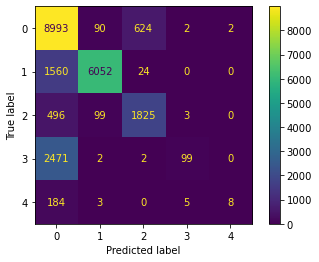

In [15]:
from sklearn.linear_model import LogisticRegression
start = timeit.default_timer()
clf = LogisticRegression()
clf.fit(train_x, train_Y)

#Calculate Stop time
stop = timeit.default_timer()
train_time = stop - start

#Calculate start time
start = timeit.default_timer()

# Predict the model
y_pred=clf.predict(test_x)

#Calculate Stop time
stop = timeit.default_timer()
test_time= stop - start
results = confusion_matrix(test_Y,y_pred)


precision = metrics.precision_score(test_Y, y_pred, average="weighted")
recall = metrics.recall_score(test_Y, y_pred, average="weighted")
f1Score = metrics.f1_score(test_Y, y_pred, average="weighted")

cm_display = ConfusionMatrixDisplay(results).plot()

print ("[KDD-Dataset] Model Training Time for Logistic Regression: ", train_time)
print ("[KDD-Dataset] Prediction Time for Logistic Regression: ", test_time)
print("[KDD-Dataset] Confusion Matrix for Logistic Regression:\n", results)
print("[KDD-Dataset] Classification Report for Logistic Regression:\n", classification_report(test_Y,y_pred))
print("[KDD-Dataset] Precision Logistic Regression: ", precision)
print("[KDD-Dataset] Recall Logistic Regression: ", recall)
print("[KDD-Dataset] F1 score Logistic Regression: ", f1Score)
#Taken from: 
#https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py
FP = results.sum(axis=0) - np.diag(results)  
FN = results.sum(axis=1) - np.diag(results)
TP = np.diag(results)
TN = results.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
FPR = FP.sum()/(FP.sum()+TN.sum())

print("FPR: ", FPR)
D1['LR'] = metrics.accuracy_score(test_Y, y_pred)

#### Random Forest

In [12]:
hyperparamsList = {'max_depth': np.arange(10, 50, 10).tolist(), 
                     'n_estimators': np.arange(10, 500, 50).tolist(), 
                     'criterion': ['entropy', 'gini']
                  }

clf = RandomForestClassifier()

grid = GridSearchCV(estimator=clf, param_grid=hyperparamsList, cv=2,
                    scoring='accuracy', n_jobs = 4)

grid.fit(train_x, train_Y)
print (grid.best_params_)

{'criterion': 'entropy', 'max_depth': 30, 'n_estimators': 160}


[KDD-Dataset] Model Training Time for Random Forest:  18.283547
[KDD-Dataset] Prediction Time for Random Forest:  0.48428999999998723
[KDD-Dataset] Confusion Matrix for Random Forest:
 [[9458   67  185    0    1]
 [1775 5778   83    0    0]
 [ 811  163 1449    0    0]
 [2534    0    1   38    1]
 [ 195    0    0    3    2]]
[KDD-Dataset] Classification Report for Random Forest:
               precision    recall  f1-score   support

      benign       0.64      0.97      0.77      9711
         dos       0.96      0.76      0.85      7636
       probe       0.84      0.60      0.70      2423
         r2l       0.93      0.01      0.03      2574
         u2r       0.50      0.01      0.02       200

    accuracy                           0.74     22544
   macro avg       0.77      0.47      0.47     22544
weighted avg       0.80      0.74      0.70     22544

[KDD-Dataset] Precision Random Forest:  0.8024371890972108
[KDD-Dataset] Recall Random Forest:  0.7418825408090844
[KDD-Dataset] 

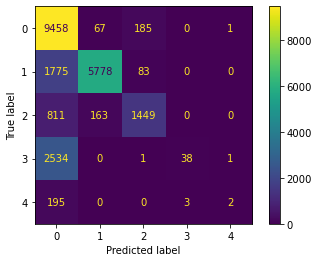

In [13]:
start = timeit.default_timer()

clf = RandomForestClassifier(n_estimators = grid.best_params_['n_estimators'], 
                             max_depth = grid.best_params_['max_depth'])

clf.fit(train_x, train_Y)

#Calculate Stop time
stop = timeit.default_timer()
train_time = stop - start

#Calculate start time
start = timeit.default_timer()

# Predict the model
y_pred=clf.predict(test_x)

#Calculate Stop time
stop = timeit.default_timer()
test_time= stop - start
results = confusion_matrix(test_Y,y_pred)


precision = metrics.precision_score(test_Y, y_pred, average="weighted")
recall = metrics.recall_score(test_Y, y_pred, average="weighted")
f1Score = metrics.f1_score(test_Y, y_pred, average="weighted")

cm_display = ConfusionMatrixDisplay(results).plot()

print ("[KDD-Dataset] Model Training Time for Random Forest: ", train_time)
print ("[KDD-Dataset] Prediction Time for Random Forest: ", test_time)
print("[KDD-Dataset] Confusion Matrix for Random Forest:\n", results)
print("[KDD-Dataset] Classification Report for Random Forest:\n", classification_report(test_Y,y_pred))
print("[KDD-Dataset] Precision Random Forest: ", precision)
print("[KDD-Dataset] Recall Random Forest: ", recall)
print("[KDD-Dataset] F1 score Random Forest: ", f1Score)
#Taken from: 
#https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py
FP = results.sum(axis=0) - np.diag(results)  
FN = results.sum(axis=1) - np.diag(results)
TP = np.diag(results)
TN = results.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
FPR = FP.sum()/(FP.sum()+TN.sum())

print("FPR: ", FPR)
D1['RF'] = metrics.accuracy_score(test_Y, y_pred)

#### Adaboost

[KDD-Dataset] Model Training Time for Adaboost:  49.60537739999927
[KDD-Dataset] Prediction Time for Adaboost:  1.3512893000006443
[KDD-Dataset] Confusion Matrix for Adaboost:
 [[7878 1382   94    5  352]
 [1692 4586 1350    0    8]
 [ 174  532 1714    0    3]
 [2203  328   27   13    3]
 [  90    0  100    5    5]]
[KDD-Dataset] Classification Report for Adaboost:
               precision    recall  f1-score   support

      benign       0.65      0.81      0.72      9711
         dos       0.67      0.60      0.63      7636
       probe       0.52      0.71      0.60      2423
         r2l       0.57      0.01      0.01      2574
         u2r       0.01      0.03      0.02       200

    accuracy                           0.63     22544
   macro avg       0.49      0.43      0.40     22544
weighted avg       0.63      0.63      0.59     22544

[KDD-Dataset] Precision Adaboost:  0.6301529440325596
[KDD-Dataset] Recall Adaboost:  0.6297019162526615
[KDD-Dataset] F1 score Adaboost:  0.5

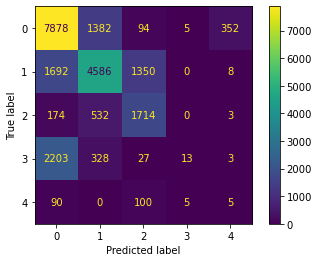

In [17]:
from sklearn.ensemble import AdaBoostClassifier
start = timeit.default_timer()

clf = AdaBoostClassifier(n_estimators=100, random_state=24)
clf.fit(train_x, train_Y)

#Calculate Stop time
stop = timeit.default_timer()
train_time = stop - start

#Calculate start time
start = timeit.default_timer()

# Predict the model
y_pred=clf.predict(test_x)

#Calculate Stop time
stop = timeit.default_timer()
test_time= stop - start
results = confusion_matrix(test_Y,y_pred)


precision = metrics.precision_score(test_Y, y_pred, average="weighted")
recall = metrics.recall_score(test_Y, y_pred, average="weighted")
f1Score = metrics.f1_score(test_Y, y_pred, average="weighted")

cm_display = ConfusionMatrixDisplay(results).plot()

print ("[KDD-Dataset] Model Training Time for Adaboost: ", train_time)
print ("[KDD-Dataset] Prediction Time for Adaboost: ", test_time)
print("[KDD-Dataset] Confusion Matrix for Adaboost:\n", results)
print("[KDD-Dataset] Classification Report for Adaboost:\n", classification_report(test_Y,y_pred))
print("[KDD-Dataset] Precision Adaboost: ", precision)
print("[KDD-Dataset] Recall Adaboost: ", recall)
print("[KDD-Dataset] F1 score Adaboost: ", f1Score)
#Taken from: 
#https://stackoverflow.com/questions/50666091/true-positive-rate-and-false-positive-rate-tpr-fpr-for-multi-class-data-in-py
FP = results.sum(axis=0) - np.diag(results)  
FN = results.sum(axis=1) - np.diag(results)
TP = np.diag(results)
TN = results.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)
FPR = FP.sum()/(FP.sum()+TN.sum())

print("FPR: ", FPR)
D1['Ada'] = metrics.accuracy_score(test_Y, y_pred)

### Processed_Combined_IoT_dataset

In [14]:
X, Y = data2.loc[:, data2.columns != 'label'], data2["label"]

In [15]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_Y, test_Y = train_test_split(X, Y, test_size=0.3, random_state=1).copy()

#### Decision Tree

In [16]:
hyperparamsList = {'max_depth': np.arange(10, 200, 10).tolist(), 
                  }

clf = DecisionTreeClassifier()

grid = GridSearchCV(estimator=clf, param_grid=hyperparamsList, cv=2,
                    scoring='accuracy', n_jobs = 4)

grid.fit(train_x, train_Y)
print (grid.best_params_)

{'max_depth': 60}


[IoT-Dataset] Precision DT:  0.9308879445314248
[IoT-Dataset] Recall DT:  0.7108302555453556
[IoT-Dataset] Model Training Time for DT:  2.575476199999912
[IoT-Dataset] Prediction Time for DT:  0.059181700000067394
[IoT-Dataset] Confusion Matrix for DT:
 [[71023  2472]
 [13545 33296]]
[IoT-Dataset] Classification Report for DT:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90     73495
           1       0.93      0.71      0.81     46841

    accuracy                           0.87    120336
   macro avg       0.89      0.84      0.85    120336
weighted avg       0.88      0.87      0.86    120336

[IoT-Dataset] Precision DT:  [0.38925176 0.93088794 1.        ]
[IoT-Dataset] Recall DT:  [1.         0.71083026 0.        ]
[IoT-Dataset] F1 score DT:  0.8061107143289471
tp:  33296
fp:  2472
fn:  13545
tn:  71023
FPR:  0.03363494115245935


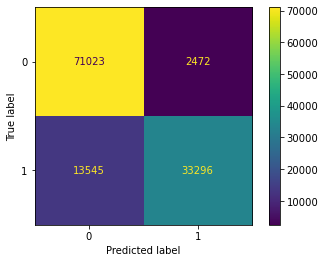

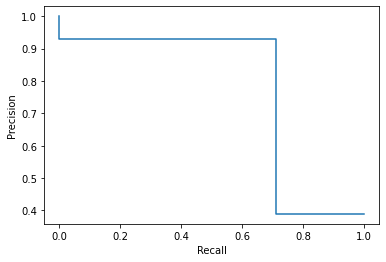

In [17]:
# 5-class classification version

start = timeit.default_timer()
clf = DecisionTreeClassifier(max_depth = grid.best_params_['max_depth'],random_state=17)

clf.fit(train_x, train_Y)

#Calculate Stop time
stop = timeit.default_timer()
train_time = stop - start

#Calculate start time
start = timeit.default_timer()

# Predict the model
y_pred=clf.predict(test_x)

#Calculate Stop time
stop = timeit.default_timer()
test_time= stop - start
results = confusion_matrix(test_Y,y_pred)


precision = metrics.precision_score(test_Y, y_pred)
recall = metrics.recall_score(test_Y, y_pred)
print("[IoT-Dataset] Precision DT: ", precision)
print("[IoT-Dataset] Recall DT: ", recall)
precision, recall, _ = precision_recall_curve(test_Y, y_pred)

f1Score = metrics.f1_score(test_Y, y_pred)

cm_display = ConfusionMatrixDisplay(results).plot()
PrecisionRecallDisplay(precision=precision, recall=recall).plot()

print ("[IoT-Dataset] Model Training Time for DT: ", train_time)
print ("[IoT-Dataset] Prediction Time for DT: ", test_time)
print("[IoT-Dataset] Confusion Matrix for DT:\n", results)
print("[IoT-Dataset] Classification Report for DT:\n", classification_report(test_Y,y_pred))
print("[IoT-Dataset] Precision DT: ", precision)
print("[IoT-Dataset] Recall DT: ", recall)
print("[IoT-Dataset] F1 score DT: ", f1Score)
tn, fp, fn, tp = results.ravel()
fpr = fp/(tn + fp)
print("tp: ", tp)
print("fp: ", fp)
print("fn: ", fn)
print("tn: ", tn)
print("FPR: ", fpr)
D2['DT'] = metrics.accuracy_score(test_Y, y_pred)

#### KNN

In [21]:
###### start = timeit.default_timer()
clf = KNeighborsClassifier()
clf.fit(train_x, train_Y)

#Calculate Stop time
stop = timeit.default_timer()
train_time = stop - start

#Calculate start time
start = timeit.default_timer()

# Predict the model
y_pred=clf.predict(test_x)

#Calculate Stop time
stop = timeit.default_timer()
test_time= stop - start
results = confusion_matrix(test_Y,y_pred)


precision = metrics.precision_score(test_Y, y_pred)
recall = metrics.recall_score(test_Y, y_pred)
print("[IoT-Dataset] Precision: ", precision)
print("[IoT-Dataset] Recall: ", recall)
precision, recall, _ = precision_recall_curve(test_Y, y_pred)
f1Score = metrics.f1_score(test_Y, y_pred)

cm_display = ConfusionMatrixDisplay(results).plot()
PrecisionRecallDisplay(precision=precision, recall=recall).plot()

print ("[IoT-Dataset] Model Training Time for knn: ", train_time)
print ("[IoT-Dataset] Prediction Time for knn: ", test_time)
print("[IoT-Dataset] Confusion Matrix for knn:\n", results)
print("[IoT-Dataset] Classification Report for knn:\n", classification_report(test_Y,y_pred))
print("[IoT-Dataset] Precision knn: ", precision)
print("[IoT-Dataset] Recall knn: ", recall)
print("[IoT-Dataset] F1 score knn: ", f1Score)
tn, fp, fn, tp = results.ravel()
fpr = fp/(tn + fp)
print("FPR: ", fpr)
D2['KNN'] = metrics.accuracy_score(test_Y, y_pred)

KeyboardInterrupt: 

#### MLP

In [ ]:
start = timeit.default_timer()

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=1)
clf.fit(train_x, train_Y)

#Calculate Stop time
stop = timeit.default_timer()
train_time = stop - start

#Calculate start time
start = timeit.default_timer()

# Predict the model
y_pred=clf.predict(test_x)

#Calculate Stop time
stop = timeit.default_timer()
test_time= stop - start
results = confusion_matrix(test_Y,y_pred)


precision = metrics.precision_score(test_Y, y_pred)
recall = metrics.recall_score(test_Y, y_pred)
print("[IoT-Dataset] Precision: ", precision)
print("[IoT-Dataset] Recall: ", recall)
precision, recall, _ = precision_recall_curve(test_Y, y_pred)
f1Score = metrics.f1_score(test_Y, y_pred)

cm_display = ConfusionMatrixDisplay(results).plot()
PrecisionRecallDisplay(precision=precision, recall=recall).plot()

print ("[IoT-Dataset] Model Training Time for mlp: ", train_time)
print ("[IoT-Dataset] Prediction Time for mlp: ", test_time)
print("[IoT-Dataset] Confusion Matrix for mlp:\n", results)
print("[IoT-Dataset] Classification Report for mlp:\n", classification_report(test_Y,y_pred))
print("[IoT-Dataset] Precision mlp: ", precision)
print("[IoT-Dataset] Recall mlp: ", recall)
print("[IoT-Dataset] F1 score mlp: ", f1Score)
tn, fp, fn, tp = results.ravel()
fpr = fp/(tn + fp)
print("FPR: ", fpr)
D2['MLP'] = metrics.accuracy_score(test_Y, y_pred)

#### Logistic Regression

In [ ]:
start = timeit.default_timer()

clf = LogisticRegression()
clf.fit(train_x, train_Y)

#Calculate Stop time
stop = timeit.default_timer()
train_time = stop - start

#Calculate start time
start = timeit.default_timer()

# Predict the model
y_pred=clf.predict(test_x)

#Calculate Stop time
stop = timeit.default_timer()
test_time= stop - start
results = confusion_matrix(test_Y,y_pred)


precision = metrics.precision_score(test_Y, y_pred)
recall = metrics.recall_score(test_Y, y_pred)
print("[IoT-Dataset] Precision: ", precision)
print("[IoT-Dataset] Recall: ", recall)
precision, recall, _ = precision_recall_curve(test_Y, y_pred)
f1Score = metrics.f1_score(test_Y, y_pred)

cm_display = ConfusionMatrixDisplay(results).plot()
PrecisionRecallDisplay(precision=precision, recall=recall).plot()

print ("[IoT-Dataset] Model Training Time for Logistic Regression: ", train_time)
print ("[IoT-Dataset] Prediction Time for Logistic Regression: ", test_time)
print("[IoT-Dataset] Confusion Matrix for Logistic Regression:\n", results)
print("[IoT-Dataset] Classification Report for Logistic Regression:\n", classification_report(test_Y,y_pred))
print("[IoT-Dataset] Precision Logistic Regression: ", precision)
print("[IoT-Dataset] Recall Logistic Regression: ", recall)
print("[IoT-Dataset] F1 score Logistic Regression: ", f1Score)
tn, fp, fn, tp = results.ravel()
fpr = fp/(tn + fp)
print("FPR: ", fpr)
D2['LR'] = metrics.accuracy_score(test_Y, y_pred)

#### Random Forest

In [18]:
import numpy as np
from sklearn.model_selection import GridSearchCV

hyperparamsList = {'max_depth': np.arange(10, 50, 10).tolist(), 
                     'n_estimators': np.arange(10, 500, 50).tolist(), 
                     'criterion': ['entropy', 'gini']
                  }

clf = RandomForestClassifier()

grid = GridSearchCV(estimator=clf, param_grid=hyperparamsList, cv=2,
                    scoring='accuracy', n_jobs = 4)

grid.fit(train_x, train_Y)
print (grid.best_params_)

{'criterion': 'gini', 'max_depth': 40, 'n_estimators': 260}


[IoT-Dataset] Precision:  0.9778328027355264
[IoT-Dataset] Recall:  0.7081830020708354
[IoT-Dataset] Model Training Time for Random Forest:  96.73630689999982
[IoT-Dataset] Prediction Time for Random Forest:  5.158274100000199
[IoT-Dataset] Confusion Matrix for Random Forest:
 [[72743   752]
 [13669 33172]]
[IoT-Dataset] Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91     73495
           1       0.98      0.71      0.82     46841

    accuracy                           0.88    120336
   macro avg       0.91      0.85      0.87    120336
weighted avg       0.89      0.88      0.88    120336

[IoT-Dataset] Precision Random Forest:  [0.38925176 0.9778328  1.        ]
[IoT-Dataset] Recall Random Forest:  [1.       0.708183 0.      ]
[IoT-Dataset] F1 score Random Forest:  0.8214449328298149
FPR:  0.010231988570651065


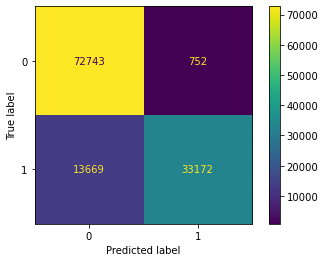

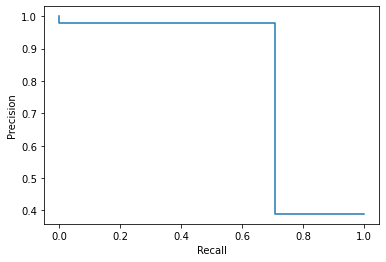

In [19]:
#Calculate start time
start = timeit.default_timer()

clf=RandomForestClassifier(n_estimators = grid.best_params_['n_estimators'], 
                           max_depth = grid.best_params_['max_depth'],
                          criterion = grid.best_params_['criterion'])

clf.fit(train_x, train_Y)

#Calculate Stop time
stop = timeit.default_timer()
train_time = stop - start

#Calculate start time
start = timeit.default_timer()

# Predict the model
y_pred=clf.predict(test_x)

#Calculate Stop time
stop = timeit.default_timer()
test_time= stop - start
results = confusion_matrix(test_Y,y_pred)


precision = metrics.precision_score(test_Y, y_pred)
recall = metrics.recall_score(test_Y, y_pred)
print("[IoT-Dataset] Precision: ", precision)
print("[IoT-Dataset] Recall: ", recall)
precision, recall, _ = precision_recall_curve(test_Y, y_pred)
f1Score = metrics.f1_score(test_Y, y_pred)

cm_display = ConfusionMatrixDisplay(results).plot()
PrecisionRecallDisplay(precision=precision, recall=recall).plot()

print ("[IoT-Dataset] Model Training Time for Random Forest: ", train_time)
print ("[IoT-Dataset] Prediction Time for Random Forest: ", test_time)
print("[IoT-Dataset] Confusion Matrix for Random Forest:\n", results)
print("[IoT-Dataset] Classification Report for Random Forest:\n", classification_report(test_Y,y_pred))
print("[IoT-Dataset] Precision Random Forest: ", precision)
print("[IoT-Dataset] Recall Random Forest: ", recall)
print("[IoT-Dataset] F1 score Random Forest: ", f1Score)
tn, fp, fn, tp = results.ravel()
fpr = fp/(tn + fp)
print("FPR: ", fpr)
D2['RF'] = metrics.accuracy_score(test_Y, y_pred)

#### AdaBoost

[IoT-Dataset] Precision:  0.898454822616408
[IoT-Dataset] Recall:  0.5536389060865481
[IoT-Dataset] Model Training Time for Adaboost:  15.426053499999853
[IoT-Dataset] Prediction Time for Adaboost:  1.5675397999998495
[IoT-Dataset] Confusion Matrix for Adaboost:
 [[70564  2931]
 [20908 25933]]
[IoT-Dataset] Classification Report for Adaboost:
               precision    recall  f1-score   support

           0       0.77      0.96      0.86     73495
           1       0.90      0.55      0.69     46841

    accuracy                           0.80    120336
   macro avg       0.83      0.76      0.77    120336
weighted avg       0.82      0.80      0.79    120336

[IoT-Dataset] Precision Adaboost:  [0.38925176 0.89845482 1.        ]
[IoT-Dataset] Recall Adaboost:  [1.         0.55363891 0.        ]
[IoT-Dataset] F1 score Adaboost:  0.6851066640248332
FPR:  0.03988026396353493


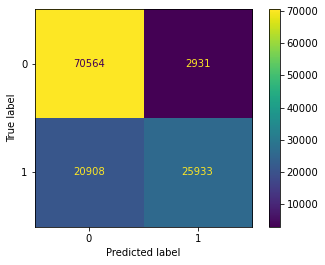

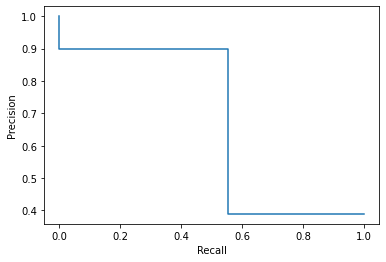

In [24]:
from sklearn.ensemble import AdaBoostClassifier
start = timeit.default_timer()

clf = AdaBoostClassifier(n_estimators=100, random_state=24)
clf.fit(train_x, train_Y)

#Calculate Stop time
stop = timeit.default_timer()
train_time = stop - start

#Calculate start time
start = timeit.default_timer()

# Predict the model
y_pred=clf.predict(test_x)

#Calculate Stop time
stop = timeit.default_timer()
test_time= stop - start
results = confusion_matrix(test_Y,y_pred)


precision = metrics.precision_score(test_Y, y_pred)
recall = metrics.recall_score(test_Y, y_pred)
print("[IoT-Dataset] Precision: ", precision)
print("[IoT-Dataset] Recall: ", recall)
precision, recall, _ = precision_recall_curve(test_Y, y_pred)
f1Score = metrics.f1_score(test_Y, y_pred)

cm_display = ConfusionMatrixDisplay(results).plot()
PrecisionRecallDisplay(precision=precision, recall=recall).plot()

print ("[IoT-Dataset] Model Training Time for Adaboost: ", train_time)
print ("[IoT-Dataset] Prediction Time for Adaboost: ", test_time)
print("[IoT-Dataset] Confusion Matrix for Adaboost:\n", results)
print("[IoT-Dataset] Classification Report for Adaboost:\n", classification_report(test_Y,y_pred))
print("[IoT-Dataset] Precision Adaboost: ", precision)
print("[IoT-Dataset] Recall Adaboost: ", recall)
print("[IoT-Dataset] F1 score Adaboost: ", f1Score)
tn, fp, fn, tp = results.ravel()
fpr = fp/(tn + fp)
print("FPR: ", fpr)
D2['Ada'] = metrics.accuracy_score(test_Y, y_pred)

#### SVM

In [25]:
#from sklearn.preprocessing import StandardScaler
#start = timeit.default_timer()
#clf = make_pipeline(StandardScaler(), svm.LinearSVC(dual=False))
#clf.fit(train_x, train_Y)
#
##Calculate Stop time
#stop = timeit.default_timer()
#train_time = stop - start
#
##Calculate start time
#start = timeit.default_timer()
#
## Predict the model
#y_pred=clf.predict(test_x)
#
##Calculate Stop time
#stop = timeit.default_timer()
#test_time= stop - start
#results = confusion_matrix(test_Y,y_pred)
#
#
#precision = metrics.precision_score(test_Y, y_pred)
#recall = metrics.recall_score(test_Y, y_pred)
#print("[IoT-Dataset] Precision: ", precision)
#print("[IoT-Dataset] Recall: ", recall)
#precision, recall, _ = precision_recall_curve(test_Y, y_pred)
#f1Score = metrics.f1_score(test_Y, y_pred)
#
#cm_display = ConfusionMatrixDisplay(results).plot()
#PrecisionRecallDisplay(precision=precision, recall=recall).plot()
#
#print ("[IoT-Dataset] Model Training Time for svm: ", train_time)
#print ("[IoT-Dataset] Prediction Time for svm: ", test_time)
#print("[IoT-Dataset] Confusion Matrix for svm:\n", results)
#print("[IoT-Dataset] Classification Report for svm:\n", classification_report(test_Y,y_pred))
#print("[IoT-Dataset] Precision svm: ", precision)
#print("[IoT-Dataset] Recall svm: ", recall)
#print("[IoT-Dataset] F1 score svm: ", f1Score)
#tn, fp, fn, tp = results.ravel()
#fpr = fp/(tn + fp)
#print("FPR: ", fpr)
#D2['SVM'] = metrics.precision_score(test_Y, y_pred)

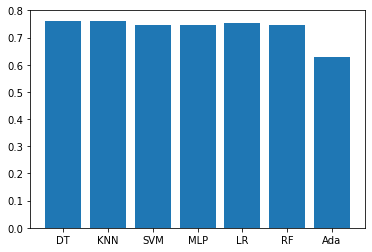

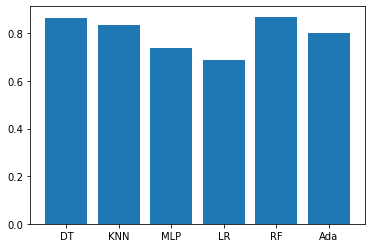

In [26]:
import matplotlib.pyplot as plt

plt.bar(range(len(D1)), list(D1.values()), align='center')
plt.xticks(range(len(D1)), list(D1.keys()))
plt.show()
plt.bar(range(len(D2)), list(D2.values()), align='center')
plt.xticks(range(len(D2)), list(D2.keys()))
plt.show()


In [27]:
D2

{'DT': 0.864761999734078,
 'KNN': 0.8332086823560697,
 'MLP': 0.7383077383326685,
 'LR': 0.6883393165802419,
 'RF': 0.8698394495412844,
 'Ada': 0.8018963568674379}